In [1159]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.read_csv('datasets/players.csv')
df2 = pd.read_csv('datasets/players_teams.csv')
df3 = pd.read_csv('datasets/awards_players.csv')
df4 = pd.read_csv('datasets/teams.csv')
df5 = pd.read_csv('datasets/teams_post.csv')
df6 = pd.read_csv('datasets/coaches.csv')
df7 = pd.read_csv('datasets/series_post.csv')

def corrige_vencedor(teams, series_post):
    # Itera sobre cada rodada ('F', 'CF', 'FR') para ajustar cada fase dos playoffs
    for round_type in ['FR', 'CF', 'F']:
        # Filtra a série específica da rodada
        series_round = series_post[series_post['round'] == round_type]
        
        # Atualiza cada série individualmente
        for _, row in series_round.iterrows():
            year = row['year']
            winner_id = row['tmIDWinner']
            loser_id = row['tmIDLoser']
            
            # Define as colunas que correspondem às rodadas
            if round_type == 'FR':
                round_column = 'firstRound'
            elif round_type == 'CF':
                round_column = 'semis'
            elif round_type == 'F':
                round_column = 'finals'
            
            # Marca o time vencedor como "W" na rodada correspondente
            teams.loc[(teams['year'] == year) & (teams['tmID'] == winner_id), round_column] = 'W'
            
            # Marca o time perdedor como "L" na rodada correspondente
            teams.loc[(teams['year'] == year) & (teams['tmID'] == loser_id), round_column] = 'L'
    
    return teams

teams_file = corrige_vencedor(df4, df7)

players_teams_file = df2.drop(columns=['lgID']) # tirar lgID de tudo porque é tudo igual

players_file = df1[df1['pos'].notna() & (df1['pos'] != '')] # tirar jogadoras com linhas vazias

players_file = players_file.drop(columns=['firstseason', 'lastseason', 'deathDate', 'collegeOther']) # dropar firstseason e lastseason porque têm os valores todos iguais, dropar deathDate porque quase ninguém morreu 
players_file['college'] = players_file['college'].apply(lambda x: 1 if pd.notnull(x) else 0) # substituir college por escolaridade

merged_df = pd.merge(players_teams_file, players_file, left_on='playerID', right_on='bioID', how='left') # merge players_teams e players

merged_df = merged_df.drop(columns=['bioID']) # tirar bioID porque já temos playerID
awards_players_file = df3.drop(columns=['lgID']) # tirar porque é tudo igual
teams_file = df4.drop(columns=['lgID', 'divID', 'tmORB','tmDRB','tmTRB','opptmORB','opptmDRB','opptmTRB','seeded']) # dropar lgID e divID porque é igual em tudo e o resto estava tudo a zero
teams_file['playoff'] = teams_file['playoff'].apply(lambda x: 1 if x=='Y' else 0) # substituir playoff por valores numericos

team_post_file = df5.drop(columns=['lgID']) # tirar lgID de tudo porque é tudo igual
series_post_file = df7.drop(columns=['lgIDWinner', 'lgIDLoser']) # tirar tudo porque é tudo igual
coaches_file = df6.drop(columns=['lgID']) # tirar lgID de tudo porque é tudo igual


awards_grouped = awards_players_file.groupby(['playerID', 'year'])['award'].apply(list).reset_index() # agrupamos numa lista todos os awards de cada jogadora em cada ano
awards_grouped['award'] = awards_grouped['award'].apply(lambda x: x if isinstance(x, list) else []) # se uma jogadora não tem awards -> lista vazia

merged_df = pd.merge(merged_df, awards_grouped, on=['playerID', 'year'], how='left') # merge do dataset que foi merged em cima com o dos awards
merged_df['award'] = merged_df['award'].apply(lambda x: x if isinstance(x, list) else []) # se uma jogadora não tem awards -> lista vazia
merged_df = pd.merge(merged_df, teams_file, on=['tmID','year'], how = 'left') # merge com o teams

merged_df = merged_df.drop(columns=['franchID', 'name']) # dropar franchID porque é igual à sigla da equipa e name porque já temos a sigla

merged_df = pd.merge(merged_df, team_post_file, on=['tmID','year'], how = 'left') # merge com o teams post

/tmp/ipykernel_2486/14480375.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  winner_summary = winner_counts.groupby(['year', 'round']).size().reset_index(name='winner_count')


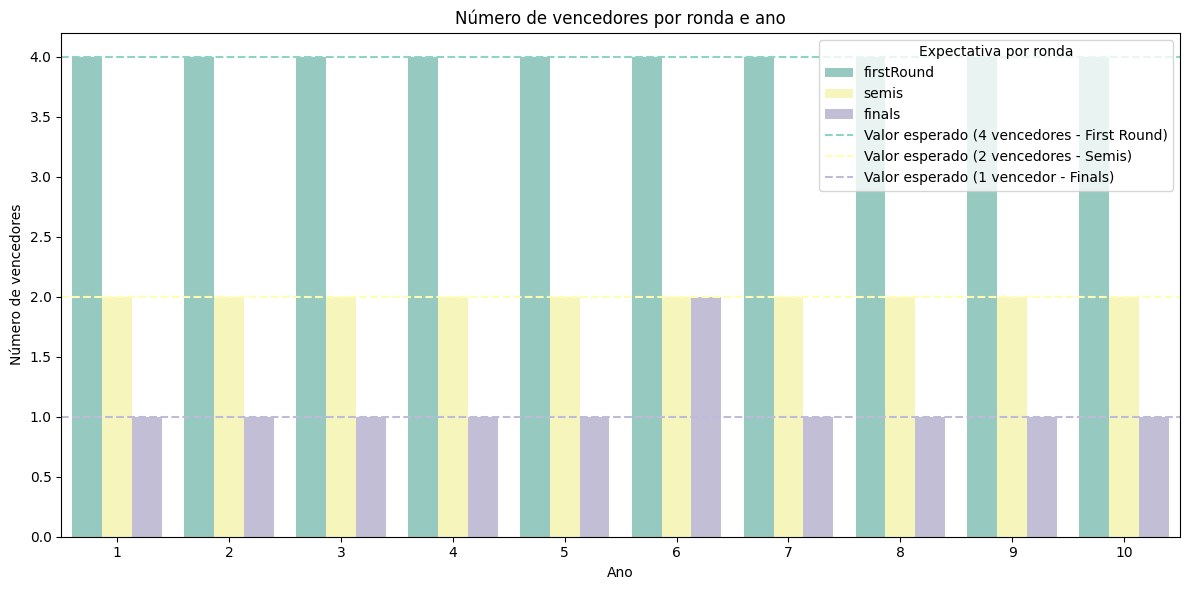

In [1160]:
teams = pd.read_csv('datasets/teams.csv')

# Transformar os dados de rodadas em formato longo
winner_counts = teams.melt(
    id_vars=['year', 'tmID'],  # Colunas fixas
    value_vars=['firstRound', 'semis', 'finals'],  # Colunas que serão transformadas
    var_name='round',  # Nome para a coluna das rodadas
    value_name='result'  # Nome para a coluna dos resultados
)

# Filtrar apenas as equipes vencedoras
winner_counts = winner_counts[winner_counts['result'] == 'W']

# Garantir a ordem correta das rodadas
round_order = ['firstRound', 'semis', 'finals']
winner_counts['round'] = pd.Categorical(winner_counts['round'], categories=round_order, ordered=True)

# Contar o número de vencedores por rodada e ano
winner_summary = winner_counts.groupby(['year', 'round']).size().reset_index(name='winner_count')

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Cores para cada rodada
round_colors = {
    'firstRound': sns.color_palette('Set3')[0],
    'semis': sns.color_palette('Set3')[1],
    'finals': sns.color_palette('Set3')[2]
}

# Criar o gráfico de barras
sns.barplot(data=winner_summary, x='year', y='winner_count', hue='round', hue_order=round_order, palette=round_colors)

# Adicionar linhas de valor esperado da mesma cor das barras
plt.axhline(4, color=round_colors['firstRound'], linestyle='--', label='Valor esperado (4 vencedores - First Round)')
plt.axhline(2, color=round_colors['semis'], linestyle='--', label='Valor esperado (2 vencedores - Semis)')
plt.axhline(1, color=round_colors['finals'], linestyle='--', label='Valor esperado (1 vencedor - Finals)')

# Personalizar o gráfico
plt.title('Número de vencedores por ronda e ano')
plt.xlabel('Ano')
plt.ylabel('Número de vencedores')
plt.legend(title='Expectativa por ronda')
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [1161]:
# Calculate min, max, and average player count for each year

player_count_per_team_year = merged_df.groupby(['year', 'tmID'])['playerID'].nunique().reset_index()
player_count_per_team_year.columns = ['Year', 'Team', 'PlayerCount']

# print(player_count_per_team_year)

summary_stats = player_count_per_team_year.groupby('Year')['PlayerCount'].agg(['min', 'max', 'mean']).reset_index()
summary_stats.columns = ['Year', 'MinPlayerCount', 'MaxPlayerCount', 'AvgPlayerCount']

summary_stats.head(10)

,Year,MinPlayerCount,MaxPlayerCount,AvgPlayerCount
0,1,11,15,13.000000
1,2,11,18,13.000000
2,3,11,15,13.562500
3,4,11,21,12.857143
4,5,11,15,12.846154
5,6,12,16,13.692308
6,7,10,16,12.857143
7,8,10,15,13.307692
8,9,12,19,14.285714
9,10,9,18,12.692308


In [1162]:
# merge do awards com os coaches

awards_coaches_file = df3.rename(columns={'playerID': 'coachID'})
coach_awards = awards_coaches_file[awards_coaches_file['award'] == 'Coach of the Year']
coach_awards_grouped = coach_awards.groupby(['coachID', 'year'])['award'].apply(list).reset_index()
coaches_file = pd.merge(coaches_file, coach_awards_grouped, on=['coachID', 'year'], how='left')

In [1163]:
# Calculate average rebounds by position, excluding secondary positions
avg_rebounds_by_pos_filtered = (
    merged_df.groupby('pos')
    .agg(oRebounds=('oRebounds', 'mean'), dRebounds=('dRebounds', 'mean'))
    .reset_index()
    .query("pos in ['G', 'F', 'C']")
)

avg_rebounds_by_pos_filtered['d_over_o_reb'] = avg_rebounds_by_pos_filtered['dRebounds'] / avg_rebounds_by_pos_filtered['oRebounds']
avg_rebounds_by_pos_filtered.head(7)

,pos,oRebounds,dRebounds,d_over_o_reb
0,C,27.624031,59.895349,2.168233
2,F,30.177606,62.218147,2.061732
5,G,13.301973,38.188164,2.870865


In [1164]:
merged_df = merged_df.drop(columns=['rebounds', 'PostRebounds']) # resultado da célula anterior, os rebounds ofensivos/defensivos mudam de acordo com a posição da jogadora, logo decidimos tirar o total de rebounds
merged_df = merged_df.rename(columns={'GP_x': 'GP_player', 'GP_y': 'GP_team'}) # haviam duas colunas com nomes iguais, uma para as jogadoras e outra para as equipas, tinham ficado uma com x e a outra com y então demos rename

In [1165]:
# Criar Novas estatisticas -> PER (Player Effiency Rating)

grouped = merged_df.groupby('year').agg({
    'o_pts': 'sum',
    'o_fga': 'sum',
    'o_oreb': 'sum',
    'o_to': 'sum',
    'o_fta': 'sum',
    'o_asts': 'sum',
    'o_fgm' : 'sum',
    'o_ftm': 'sum',
    'o_dreb':'sum',
}).reset_index()

grouped['VOP'] = grouped['o_pts'] / (grouped['o_fga'] - grouped['o_oreb'] + grouped['o_to'] + 0.44 * grouped['o_fta'])
grouped['factor'] = (2 / 3) - (0.5 * (grouped['o_asts'] / grouped['o_fgm'])) / (2 * (grouped['o_fgm'] / grouped['o_ftm']))
grouped['DRB%'] = (grouped['o_dreb'] - grouped['o_oreb']) / grouped['o_dreb']

uPER_df = merged_df.groupby(['playerID', 'year']).agg({
    'minutes': 'sum',     
    'threeMade': 'sum',   
    'assists': 'sum',     
    'fgMade': 'sum',      
    'ftMade': 'sum',      
    'turnovers': 'sum',   
    'fgAttempted': 'sum', 
    'ftAttempted': 'sum', 
    'dRebounds': 'sum',   
    'oRebounds': 'sum',   
    'steals': 'sum',      
    'blocks': 'sum',      
    'PF': 'sum'           
}).reset_index()

uPER_df = uPER_df.merge(grouped[['year', 'VOP', 'factor', 'DRB%']], on='year')

uPER_df['TRB'] = uPER_df['dRebounds'] + uPER_df['oRebounds']

uPER_df['uPER'] = (1 / uPER_df['minutes']) * (
    uPER_df['threeMade'] +
    (2/3) * uPER_df['assists'] +
    (2 - uPER_df['factor'] * (uPER_df['assists'] / uPER_df['fgMade'])) * uPER_df['fgMade'] +
    (uPER_df['ftMade'] * 0.5 * (1 + (1 - (uPER_df['assists'] / uPER_df['fgMade'])) + (2/3) * (uPER_df['assists'] / uPER_df['fgMade']))) -
    uPER_df['VOP'] * uPER_df['turnovers'] -
    uPER_df['VOP'] * uPER_df['DRB%'] * (uPER_df['fgAttempted'] - uPER_df['fgMade']) -
    uPER_df['VOP'] * 0.44 * (0.44 + (0.56 * uPER_df['DRB%'])) * (uPER_df['ftAttempted'] - uPER_df['ftMade']) +
    uPER_df['VOP'] * (1 - uPER_df['DRB%']) * uPER_df['TRB'] +
    uPER_df['VOP'] * uPER_df['DRB%'] * uPER_df['oRebounds'] +
    uPER_df['VOP'] * uPER_df['steals'] +
    uPER_df['VOP'] * uPER_df['DRB%'] * uPER_df['blocks'] -
    uPER_df['PF'] * ((grouped['o_ftm'].mean() / grouped['o_pts'].mean()) - 0.44 * (grouped['o_fta'].mean() / grouped['o_pts'].mean()) * uPER_df['VOP'])
)

lg_uPER = uPER_df.groupby('year')['uPER'].mean().reset_index()
lg_uPER.rename(columns={'uPER': 'lg_uPER'}, inplace=True)

uPER_df = uPER_df.merge(lg_uPER, on='year')

uPER_df['PER'] = uPER_df['uPER'] * (15 / uPER_df['lg_uPER'])


In [1166]:
per_to_merge = uPER_df[['playerID', 'year', 'PER']]
merged_df = merged_df.merge(per_to_merge, on=['playerID', 'year'], how='left') # adicionar o PER ao dataset

# novas estatisticas
merged_df['TS%'] = (merged_df['points'] / (2 * (merged_df['fgAttempted'] + 0.44 * merged_df['ftAttempted'])))*100
merged_df['eFG%'] = ((merged_df['fgMade'] + 0.5 * merged_df['threeMade']) / merged_df['fgAttempted'])*100
merged_df['stocks'] = (merged_df['steals'] + merged_df['blocks'])
merged_df['dar'] = ((merged_df['steals'] + merged_df['blocks'] + merged_df['oRebounds'] + merged_df['dRebounds'])/merged_df['minutes'])

# substituir por 0 colunas vazias
merged_df['PER'] = merged_df['PER'].fillna(0)
merged_df['TS%'] = merged_df['TS%'].fillna(0)
merged_df['eFG%'] = merged_df['eFG%'].fillna(0)
merged_df['stocks'] = merged_df['stocks'].fillna(0)
merged_df['dar'] = merged_df['dar'].fillna(0)

#Equipas que não foram aos playoffs
merged_df['W'] = merged_df['W'].fillna(0)
merged_df['L'] = merged_df['L'].fillna(0)

In [1167]:
def box_plot_for_each_column(dataset):
    numeric_columns = dataset.select_dtypes(include='number')
    if numeric_columns.empty:
        print("No numeric columns found in the dataset.")
    else:
        numeric_columns.boxplot(figsize=(10, 6))
        plt.title("Boxplot for all numeric columns")
        plt.xticks(rotation=45)  # Rotation in x, if necessary
        plt.show()

def pearson_correlation(dataset, size_x, size_y):
    numeric_columns = dataset.select_dtypes(include='number')
    
    if numeric_columns.empty:
        print("Nenhuma coluna numérica encontrada no dataset.")
    else:
        # Correlation matrix
        correlation_matrix = numeric_columns.corr()

        # View
        plt.figure(figsize=(size_x, size_y))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Pearson-correlation')
        plt.show()

def bar_chart_for_each_column(dataset):
    non_numeric_columns = dataset.select_dtypes(exclude='number')
    if non_numeric_columns.empty:
        print("Any non-numeric columns found in the dataset.")
    else:
        for column in non_numeric_columns.columns:
            value_counts = non_numeric_columns[column].value_counts()
            plt.figure(figsize=(10, 6))
            value_counts.plot(kind='bar')
            plt.title(f"Bar chart for '{column}'")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.tight_layout()  # Adjust layout to prevent overlap
            plt.show()

# Pie-chart for each column
def pie_chart_for_each_column(dataset):
    non_numeric_columns = dataset.select_dtypes(exclude='number')
    
    if non_numeric_columns.empty:
        print("Any non-numeric columns found in the dataset.")
    else:
        for column in non_numeric_columns.columns:
            # Count elements from different categories
            category_counts = dataset[column].value_counts()
            
            # Pie-chart
            plt.figure(figsize=(6, 6))
            category_counts.plot.pie(autopct='%1.1f%%', startangle=140)
            plt.title(f'Distribution of {column}')
            plt.ylabel('')  # Remove o rótulo do eixo Y
            plt.show()


#box_plot_for_each_column(merged_df)
#box_plot_for_each_column(coaches_file)
#box_plot_for_each_column(series_post_file)



In [1168]:
#pearson_correlation(merged_df, 100, 80)
#pearson_correlation(coaches_file, 8, 6)
#pearson_correlation(series_post_file, 8, 6)

In [1169]:
#bar_chart_for_each_column(merged_df)
#bar_chart_for_each_column(coaches_file)
#bar_chart_for_each_column(series_post_file)

In [1170]:
#pie_chart_for_each_column(merged_df)
#pie_chart_for_each_column(coaches_file)
#pie_chart_for_each_column(series_post_file)

In [1171]:
# Substituir valores nominais para valores relativos (one-attribute-per-value conversion)
def replaceGameResults(column):
    return column.apply(lambda value: '100' if value == 'W' else '010' if value == 'L' else '001')

# Aplicar a função para cada coluna específica
merged_df['firstRound'] = replaceGameResults(merged_df['firstRound'])
merged_df['semis'] = replaceGameResults(merged_df['semis'])
merged_df['finals'] = replaceGameResults(merged_df['finals'])


In [1172]:
# Guardar os datasets numa pasta
if not os.path.exists('cleanDatasets'):
    os.makedirs('cleanDatasets')

merged_df.to_csv('cleanDatasets/players_and_teams.csv', index=False)
coaches_file.to_csv('cleanDatasets/coaches_and_awards.csv', index=False)
series_post_file.to_csv('cleanDatasets/series_post.csv', index=False)

In [1173]:
# queriamos construir o dataset em relação às jogadoras então dropamos imensas colunas relativas à equipa

merged_df2 = merged_df.drop(columns=['minutes','threeMade','assists','fgMade','turnovers','fgAttempted','ftAttempted','oRebounds','steals','blocks','PF','o_ftm','o_pts','o_fta','o_pts','o_fga','o_oreb','o_to','o_asts','o_fgm','o_dreb']) # estes atributos já se encontram nas novas colunas criadas
merged_df2 = merged_df2.drop(columns=['GP_player','GS','ftMade','threeAttempted','GP_team'])
merged_df2 = merged_df2.drop(columns=['o_3pm','o_3pa','o_reb','o_pf','o_stl','o_blk','d_fgm','d_fga','d_ftm','d_fta','d_3pm','d_3pa','d_oreb','d_dreb','d_reb','d_asts','d_pf','d_stl','d_to','d_blk','d_pts'])
merged_df2 = merged_df2.drop(columns=['PostGP','PostGS','PostMinutes','PostPoints','PostoRebounds','PostdRebounds','PostAssists','PostSteals','PostBlocks','PostTurnovers','PostPF','PostfgAttempted','PostfgMade','PostftAttempted','PostftMade','PostthreeAttempted','PostthreeMade','PostDQ'])
merged_df2 = merged_df2.drop(columns=['arena'])

# substituir BirthDate por ano em que nasceram
merged_df2['birthDate'] = pd.to_datetime(merged_df['birthDate'], errors='coerce').dt.year
merged_df2 = merged_df2.rename(columns={'birthDate': 'birthYear'})

if not os.path.exists('cleanDatasets'):
    os.makedirs('cleanDatasets')

merged_df2.to_csv('cleanDatasets/advancedstatistics.csv', index=False)

In [1174]:
df9 = pd.read_csv('datasetsYear11/players_teams.csv')
df8 = pd.read_csv('datasetsYear11/coaches.csv')
df10 = pd.read_csv('datasetsYear11/teams.csv')

# Agrupar coaches por year e team, transformando em listas
coaches_grouped = df6.groupby(['year', 'tmID'])['coachID'].apply(list).reset_index()

# Fazer o merge com o ficheiro
merged_df2 = merged_df2.merge(coaches_grouped, on=['year', 'tmID'], how='left')

year11 = df9.merge(df8, on=['tmID','year'], how='left')
year11 = year11.merge(df10, on=['tmID','year'], how='left')
finalYear11 = year11[['playerID','year','tmID','coachID']]
finalYear11 = finalYear11.groupby(['playerID', 'year', 'tmID'])['coachID'].apply(list).reset_index()

# Adicionar colunas ausentes em finalYear11 com valor 0
expected_columns_merged_df2 = merged_df2.columns
finalYear11 = finalYear11.reindex(columns=expected_columns_merged_df2, fill_value=0)

# Concatenar os datasets
merged_df2 = pd.concat([merged_df2, finalYear11], ignore_index=True)

merged_df2.head(5)

,playerID,year,stint,tmID,points,dRebounds,dq,pos,height,weight,...,min,attend,W,L,PER,TS%,eFG%,stocks,dar,coachID
0,abrossv01w,2,0,MIN,343,131,2,F,74.0,169,...,6475,120607,0.0,0.0,19.293262,48.849265,42.150171,51,0.265957,[aglerbr99w]
1,abrossv01w,3,0,MIN,314,101,0,F,74.0,169,...,6475,139874,0.0,0.0,15.898093,42.774629,40.822785,52,0.245963,"[aglerbr99w, vandehe99w]"
2,abrossv01w,4,0,MIN,318,97,0,F,74.0,169,...,6850,120253,1.0,2.0,18.485960,48.457881,43.684211,55,0.247475,[mcconsu01w]
3,abrossv01w,5,0,MIN,146,57,0,F,74.0,169,...,6850,125097,0.0,2.0,14.545585,45.842753,42.446043,32,0.229437,[mcconsu01w]
4,abrossv01w,6,0,MIN,304,78,0,F,74.0,169,...,6850,113447,0.0,0.0,18.086335,49.331429,45.471014,54,0.207207,[mcconsu01w]


In [1175]:
players_stats_prevYear = merged_df2[['playerID','year','PER', 'eFG%', 'TS%','stocks','dRebounds','dar']].drop_duplicates().copy() #TODO Acrescentar aqui mais variaveis

#players_stats_prevYear['legacy_points'] = merged_df2['points']
players_stats_prevYear['legacy_points'] = merged_df2['won']
players_stats_prevYear['year'] = players_stats_prevYear['year'] + 1


players_stats_prevYear = players_stats_prevYear.merge(
    merged_df2[['playerID', 'year', 'tmID', 'playoff','coachID']], 
    on=['playerID', 'year'], 
    how='left')

players_stats_prevYear.to_csv('cleanDatasets/players_stats_prevYear.csv', index=False)

In [1176]:
#.............................Fazer a media por equipa dos valores mas pegando apenas nos 7 melhores jogadores...............

# Ordenar os jogadores dentro de cada equipe e ano com base no PER (ou outra métrica)
players_stats_prevYear_sorted = players_stats_prevYear.sort_values(by=['tmID', 'year', 'PER'], ascending=[True, True, False])

# Selecionar os 5 melhores jogadores de cada equipe e ano
top_7_players = players_stats_prevYear_sorted.groupby(['tmID', 'year']).head(5)

# Agora, calcular a média das métricas apenas para os melhores jogadores
team_year_stats = top_7_players.groupby(['tmID', 'year', 'playoff']).agg({
    'PER': 'mean',
    'TS%': 'mean',
    'eFG%': 'mean',
    'stocks': 'mean',
    'dRebounds': 'mean',
    'dar': 'mean',
    'coachID': 'first',  # Seleciona o primeiro valor da coluna (presumindo que todos sejam iguais para o grupo)
    'legacy_points' : 'mean' #Same here
}).reset_index()

playoff_teams_year11 = ["WAS", "NYL", "IND", "ATL", "SEA", "PHO", "SAS", "LAS"]

team_year_stats.loc[(team_year_stats['year'] == 11) & (team_year_stats['tmID'].isin(playoff_teams_year11)), 'playoff'] = 1

# Salva o novo dataset em um arquivo CSV
team_year_stats.to_csv('cleanDatasets/team_year_stats.csv', index=False)

team_year_stats.head(5)

,tmID,year,playoff,PER,TS%,eFG%,stocks,dRebounds,dar,coachID,legacy_points
0,ATL,9,0.0,19.894077,53.647675,50.207877,26.6,57.2,0.238431,[meadoma99w],18.8
1,ATL,10,1.0,21.751629,55.257063,51.579845,49.6,88.2,0.315709,[meadoma99w],10.8
2,ATL,11,1.0,22.453407,53.905348,50.340802,62.2,115.0,0.303681,[meadoma99w],16.8
3,CHA,2,1.0,20.571617,53.362027,47.843485,29.0,52.6,0.217976,[donovan99w],16.0
4,CHA,3,1.0,19.356376,52.945163,47.204217,36.4,73.2,0.236983,[donovan99w],18.0


In [1177]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#Para depois poder ir buscar as variavies categoricas
team_year_stats_copy = team_year_stats.copy()


# Selecionar as colunas de interesse
features = team_year_stats[['PER', 'TS%', 'eFG%','stocks','dRebounds']] #TODO Acrescentar aqui tambem

# Normalizar os dados usando MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Aplicar o PCA
pca = PCA(n_components=3) #TODO mudar aqui o numero de colunas a selecionar
pca.fit(features_scaled)

# Verificar as cargas (coeficientes) dos componentes principais
components = pca.components_

# Baseado nas cargas, você pode decidir as variáveis mais importantes
# Vamos mostrar a importância de cada variável nas componentes principais

# Calcular a soma das cargas absolutas para cada variável
importance = pd.DataFrame(abs(components), columns=['PER', 'TS%', 'eFG%','stocks','dRebounds'], index=['PC1', 'PC2','PC3']) #TODO mudar aqui as variaveis
#TODO meter tantos PC quanto variaves a selecionar
importance_sum = importance.sum(axis=0)

# Selecionar as duas variáveis mais importantes
most_important_features = importance_sum.sort_values(ascending=False).head(3) #TODO mudar aqui o numero de variaveis

# Exibir apenas os nomes das variáveis mais importantes
important_variable_names = most_important_features.index.tolist()

# Inicializar a lista de componentes a serem removidos
components_to_drop = ['PER', 'TS%', 'eFG%','stocks','dRebounds','dar'] #TODO mudar aqui as variavies (TODOS OS ATRIBUTOS AQUI)
#TODO nao esquecer de aqui adicionar as nao numericas, como os coaches

# Remover as variáveis mais importantes da lista de componentes a serem removidos
components_to_drop = [col for col in components_to_drop if col not in important_variable_names]

team_year_stats=team_year_stats.drop(columns=components_to_drop)

#Adicionar as variaveis categoricas, como os coaches, que nao passaram no processo de PCA
team_year_stats['coachID'] = team_year_stats_copy['coachID']
#team_year_stats['legacy_points'] = team_year_stats_copy['legacy_points']
#important_variable_names.append('legacy_points')

# Exibir o resultado
print(team_year_stats)

    tmID  year  playoff        PER       eFG%  stocks  \
0    ATL     9      0.0  19.894077  50.207877    26.6   
1    ATL    10      1.0  21.751629  51.579845    49.6   
2    ATL    11      1.0  22.453407  50.340802    62.2   
3    CHA     2      1.0  20.571617  47.843485    29.0   
4    CHA     3      1.0  19.356376  47.204217    36.4   
..   ...   ...      ...        ...        ...     ...   
133  WAS     7      1.0  20.574946  51.330317    39.4   
134  WAS     8      0.0  21.686321  55.716693    47.8   
135  WAS     9      0.0  21.568455  45.065012    47.0   
136  WAS    10      1.0  19.989199  51.201160    32.2   
137  WAS    11      1.0  18.205681  45.189144    57.8   

                      coachID  legacy_points  
0                [meadoma99w]           18.8  
1                [meadoma99w]           10.8  
2                [meadoma99w]           16.8  
3                [donovan99w]           16.0  
4                [donovan99w]           18.0  
..                        ...    

In [1178]:
# Normalizar os dados 

# Selecionar apenas colunas numéricas
# Lista de colunas a normalizar
columns_to_normalize = ['PER', 'eFG%', 'stocks','legacy_points'] #TODO baseado nas colunas selecionadas do dataset de cima

# Aplicar a normalização apenas nas colunas selecionadas
team_year_stats[columns_to_normalize] = team_year_stats[columns_to_normalize].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Verificar o resultado
print(team_year_stats.head())


  tmID  year  playoff       PER      eFG%    stocks       coachID  \
0  ATL     9      0.0  0.424361  0.642733  0.182965  [meadoma99w]   
1  ATL    10      1.0  0.569981  0.695814  0.545741  [meadoma99w]   
2  ATL    11      1.0  0.624995  0.647876  0.744479  [meadoma99w]   
3  CHA     2      1.0  0.477476  0.551256  0.220820  [donovan99w]   
4  CHA     3      1.0  0.382209  0.526523  0.337539  [donovan99w]   

   legacy_points  
0       0.609524  
1       0.228571  
2       0.514286  
3       0.476190  
4       0.571429  


In [1179]:
""" #Passar as colunas que nao sao numericas para numericas
# One-Hot Encoding e é útil para transformar colunas categóricas em representações numéricas binárias.

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Codificando a lista de coaches em colunas binárias
coach_dummies = mlb.fit_transform(team_year_stats['coachID'])

# Adicionando as novas colunas no dataframe original
coach_columns = mlb.classes_
team_year_stats = team_year_stats.join(pd.DataFrame(coach_dummies, columns=coach_columns))

# Adicionando os nomes das novas colunas à lista de variáveis importantes
important_variable_names.extend(coach_columns) """

" #Passar as colunas que nao sao numericas para numericas\n# One-Hot Encoding e é útil para transformar colunas categóricas em representações numéricas binárias.\n\nfrom sklearn.preprocessing import MultiLabelBinarizer\n\nmlb = MultiLabelBinarizer()\n\n# Codificando a lista de coaches em colunas binárias\ncoach_dummies = mlb.fit_transform(team_year_stats['coachID'])\n\n# Adicionando as novas colunas no dataframe original\ncoach_columns = mlb.classes_\nteam_year_stats = team_year_stats.join(pd.DataFrame(coach_dummies, columns=coach_columns))\n\n# Adicionando os nomes das novas colunas à lista de variáveis importantes\nimportant_variable_names.extend(coach_columns) "

In [1180]:
#Dividir o dataset para treino, validacao e teste 

dataset_treino = team_year_stats[(team_year_stats['year'] >= 6) & (team_year_stats['year'] <= 10)]
dataset_teste = team_year_stats[team_year_stats['year'] == 11]

In [1181]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb

# Features (X) e alvo (y)
X_treino = dataset_treino[important_variable_names] #Antigamente 'PER', 'TS%', 'eFG%'
y_treino = dataset_treino['playoff']

X_teste = dataset_teste[important_variable_names]
y_teste = dataset_teste['playoff']

X_treino.head(20)


,PER,stocks,eFG%
0,0.424361,0.182965,0.642733
1,0.569981,0.545741,0.695814
7,0.533894,0.511041,0.514482
8,0.234427,0.422713,0.229602
9,0.313671,0.211356,0.496138
10,0.255074,0.517350,0.430072
11,0.510578,0.410095,0.492579
12,0.434645,0.630915,0.494162
19,0.539403,0.684543,0.575949
20,0.696604,0.649842,0.605482


In [1182]:
#Criar ficheiros para guardar resultados e avaliar
dataset_resultados = pd.DataFrame({})

dataset_resultados["playoff"] = dataset_teste["playoff"]

In [1183]:
# Inicializar o modelo de regressão linear
modelo = RandomForestRegressor()

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["RandomForestRegressor"] = y_pred_teste

/tmp/ipykernel_2486/597684550.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1184]:
# Inicializar o modelo de regressão linear
modelo = GradientBoostingRegressor()

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["GradientBoostingRegressor"] = y_pred_teste

/tmp/ipykernel_2486/450214780.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1185]:
# Inicializar o modelo de regressão linear
modelo = LinearRegression()

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["LinearRegression"] = y_pred_teste

/tmp/ipykernel_2486/3123343135.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1186]:
#::::::::::::::::::::Este modelo é uma variante da regressão linear que usa regularização L2 para reduzir overfitting.::::::::::::::::

# Inicializar o modelo de Ridge Regression
modelo = Ridge(alpha=1.0)  # alpha controla o nível de regularização

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["Ridge"] = y_pred_teste


/tmp/ipykernel_2486/1713031855.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1187]:
# Similar ao Ridge, mas utiliza regularização L1. Tende a eliminar variáveis menos importantes, útil para seleção de features.
# Inicializar o modelo de Lasso Regression
modelo = Lasso(alpha=0.1, random_state=42)  # alpha controla a força da regularização

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

/tmp/ipykernel_2486/977365062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1188]:
# Combina as regularizações L1 (Lasso) e L2 (Ridge).
# Inicializar o modelo de Elastic Net
modelo = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
# `alpha` controla a força total da regularização.
# `l1_ratio` controla a proporção de regularização L1 (Lasso) em relação à L2 (Ridge).

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

/tmp/ipykernel_2486/151494901.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1189]:
# Inicializar o modelo de MLP
modelo = MLPRegressor(hidden_layer_sizes=(100, 50),  # Camadas ocultas com 100 e 50 neurônios
                      activation='relu',            # Função de ativação
                      solver='adam',                # Otimizador
                      max_iter=500,                 # Número máximo de iterações
                      random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["MLPRegressor_relu"] = y_pred_teste


/tmp/ipykernel_2486/1530820846.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1190]:
# Inicializar o modelo de MLP
modelo = MLPRegressor(hidden_layer_sizes=(100, 50),  # Camadas ocultas com 100 e 50 neurônios
                      activation='tanh',            # Função de ativação
                      solver='adam',                # Otimizador
                      max_iter=500,                 # Número máximo de iterações
                      random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["MLPRegressor_tanh"] = y_pred_teste

/tmp/ipykernel_2486/3422886681.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1191]:
# Inicializar o modelo de MLP
modelo = MLPRegressor(hidden_layer_sizes=(100, 50),  # Camadas ocultas com 100 e 50 neurônios
                      activation='logistic',            # Função de ativação
                      solver='adam',                # Otimizador
                      max_iter=500,                 # Número máximo de iterações
                      random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["MLPRegressor_logistic"] = y_pred_teste

/tmp/ipykernel_2486/989847951.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1192]:
import numpy as np

# Inicializar o modelo sequencial
modelo = Sequential()

# Adicionar camadas
modelo.add(Dense(64, activation='relu', input_shape=(X_treino.shape[1],)))  # Primeira camada oculta
modelo.add(Dense(32, activation='relu'))  # Segunda camada oculta
modelo.add(Dense(1))  # Camada de saída (regressão)

# Compilar o modelo
modelo.compile(optimizer='adam', loss='mse')

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste).flatten()  # Flatten para transformar em 1D

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["Sequential_relu"] = y_pred_teste

/home/edu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.6473 - val_loss: 0.7110
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5905 - val_loss: 0.6161
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4926 - val_loss: 0.5322
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4179 - val_loss: 0.4605
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3596 - val_loss: 0.3994
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3440 - val_loss: 0.3464
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3001 - val_loss: 0.3020
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2658 - val_loss: 0.2655
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2479 - val_loss: 0.2377
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2393 - val_loss: 0.2177
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2307 - val_loss: 0.2045
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2300 - val_loss: 0.1962


/tmp/ipykernel_2486/2146543663.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1193]:
import numpy as np

# Inicializar o modelo sequencial
modelo = Sequential()

# Adicionar camadas
modelo.add(Dense(64, activation='tanh', input_shape=(X_treino.shape[1],)))  # Primeira camada oculta
modelo.add(Dense(32, activation='tanh'))  # Segunda camada oculta
modelo.add(Dense(1))  # Camada de saída (regressão)

# Compilar o modelo
modelo.compile(optimizer='adam', loss='mse')

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste).flatten()  # Flatten para transformar em 1D

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["Sequential_tanh"] = y_pred_teste

Epoch 1/50


/home/edu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.5753 - val_loss: 0.5044
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3770 - val_loss: 0.3371
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2833 - val_loss: 0.2371
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2314 - val_loss: 0.1939
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2302 - val_loss: 0.1852
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2530 - val_loss: 0.1882
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2764 - val_loss: 0.1891
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2664 - val_loss: 0.1865
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2653 - val_loss: 0.1848
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2497 - val_loss: 0.1885
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2331 - val_loss: 0.1983
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2218 - val_loss: 0.2123
Epoch 13/50

/tmp/ipykernel_2486/2325067666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1194]:
# Inicializar o modelo de regressão com Extra Trees
modelo = ExtraTreesRegressor(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["ExtraTreesRegressor"] = y_pred_teste

/tmp/ipykernel_2486/4200620747.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1195]:
# Inicializar o modelo ElasticNet
modelo = ElasticNet(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["ElasticNet"] = y_pred_teste


/tmp/ipykernel_2486/2178884686.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1196]:
# Inicializar o modelo XGBoost Regressor
modelo = xgb.XGBRegressor(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["XGBRegressor"] = y_pred_teste


/tmp/ipykernel_2486/4215414685.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1197]:
# Inicializar o modelo LightGBM Regressor
modelo = lgb.LGBMRegressor(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["LGBMRegressor"] = y_pred_teste



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 67, number of used features: 3
[LightGBM] [Info] Start training from score 0.597015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/tmp/ipykernel_2486/191379248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [1198]:
# Inicializar o modelo de regressão com Gradient Boosting
modelo = GradientBoostingRegressor(random_state=42) #TODO porque foi o melhor modelo até agora

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

# Critério de correção
# 1. Quando 'playoff' é 1, 'playoff_previsto' deve ser > 0.5
# 2. Quando 'playoff' é 0, 'playoff_previsto' deve ser <= 0.5

# Criar uma coluna indicando se a previsão está correta
dataset_teste['correto'] = ((dataset_teste['playoff'] == 1) & (dataset_teste['playoff_previsto'] > 0.5)) | \
                           ((dataset_teste['playoff'] == 0) & (dataset_teste['playoff_previsto'] <= 0.5))

# Contar o número de previsões corretas
corretos = dataset_teste['correto'].sum()

# Número total de exemplos
total = len(dataset_teste)

# Exibir o resultado
print(f"Previsões corretas: {corretos} de {total} ({(corretos / total) * 100:.2f}%)")

dataset_resultados["GradientBoostingRegressor"] = y_pred_teste

dataset_teste.head(20)


Previsões corretas: 10 de 12 (83.33%)


/tmp/ipykernel_2486/3252675411.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste
/tmp/ipykernel_2486/3252675411.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['correto'] = ((dataset_teste['playoff'] == 1) & (dataset_teste['playoff_previsto'] > 0.5)) | \


,tmID,year,playoff,PER,eFG%,stocks,coachID,legacy_points,playoff_previsto,correto
2,ATL,11,1.0,0.624995,0.647876,0.744479,[meadoma99w],0.514286,0.844492,True
13,CHI,11,0.0,0.348760,0.435553,0.123028,[chatmda99w],0.571429,0.427447,True
24,CON,11,0.0,0.096278,0.564124,0.302839,[thibami99w],0.380952,0.093666,True
51,IND,11,1.0,0.408788,0.579803,0.858044,[dunnli99wc],0.771429,1.097224,True
61,LAS,11,1.0,0.136049,0.614493,0.555205,[gilloje01w],0.590476,0.703297,True
73,MIN,11,0.0,0.659588,0.684414,0.495268,[reevech99w],0.419048,0.676447,False
83,NYL,11,1.0,0.507724,0.585223,0.287066,[whisejo99w],0.476190,0.198768,False
95,PHO,11,1.0,0.721483,0.636764,0.583596,[gaineco01w],0.695238,0.679309,True
114,SAS,11,1.0,0.316821,0.616847,0.694006,[hugheda99w],0.428571,0.874134,True
124,SEA,11,1.0,0.348730,0.679578,0.548896,[aglerbr99w],0.676190,0.896778,True


In [1199]:
#Para mostrar os resultados obtidos pelos varios modelos
dataset_resultados.head(20)

,playoff,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,Ridge,MLPRegressor_relu,MLPRegressor_tanh,MLPRegressor_logistic,Sequential_relu,Sequential_tanh,ExtraTreesRegressor,ElasticNet,XGBRegressor,LGBMRegressor
2,1.0,0.85,0.844492,0.898035,0.805538,0.805200,0.855345,0.690361,0.776269,0.842885,0.80,0.597015,0.892367,0.919136
13,0.0,0.41,0.427447,0.236083,0.352463,0.336932,0.276748,0.689143,0.363475,0.212052,0.19,0.597015,0.639301,0.452077
24,0.0,0.28,0.093666,0.383654,0.414051,0.416749,0.301570,0.688954,0.384900,0.266551,0.19,0.597015,0.118734,0.418179
51,1.0,0.81,1.097224,0.933709,0.805209,0.826738,0.846815,0.690633,0.732023,0.873656,0.73,0.597015,0.772514,0.847525
61,1.0,0.69,0.703297,0.627182,0.574308,0.598737,0.511224,0.689484,0.533678,0.510428,0.47,0.597015,0.889873,0.880645
73,0.0,0.79,0.676447,0.698813,0.679955,0.673325,0.690613,0.689656,0.671794,0.639293,0.72,0.597015,0.709678,0.698712
83,1.0,0.14,0.198768,0.456738,0.508945,0.495876,0.472212,0.689273,0.507518,0.411666,0.27,0.597015,0.097820,0.223836
95,1.0,0.75,0.679309,0.773092,0.736614,0.731942,0.781333,0.690086,0.721799,0.743555,0.87,0.597015,0.268992,0.919136
114,1.0,0.83,0.874134,0.784234,0.696823,0.726977,0.691947,0.690014,0.649048,0.699764,0.82,0.597015,1.070245,0.880645
124,1.0,0.86,0.896778,0.683429,0.633620,0.647481,0.598146,0.689491,0.605821,0.575797,0.90,0.597015,1.007542,0.880645


In [1200]:
# Resultados considerando que 0.5 para cima é 1 e 0.5 para baixo da 0
from sklearn.metrics import precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Criando o DataFrame
df = pd.DataFrame(dataset_resultados)

# Inicializar lista para armazenar os resultados
resultados = []

# Loop sobre cada coluna do modelo (excluindo a coluna 'playoff')
for modelo in df.columns[1:]:
    # Cálculo de métricas de regressão
    mse = mean_squared_error(df["playoff"], df[modelo])
    mae = mean_absolute_error(df["playoff"], df[modelo])
    r2 = abs(r2_score(df["playoff"], df[modelo]))
    
    # Binarização dos valores (0.5 como limite)
    y_true = (df["playoff"] >= 0.5).astype(int)
    y_pred = (df[modelo] >= 0.5).astype(int)
    
    # Cálculo de métricas de classificação
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Adicionar os resultados à lista
    resultados.append({
        "Modelo": modelo,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy
    })

# Converter os resultados em um DataFrame
resultados_cima_baixo = pd.DataFrame(resultados)

# Exibir os resultados
resultados_cima_baixo.head(10)


,Modelo,MSE,MAE,R²,Precision,Recall,Accuracy
0,RandomForestRegressor,0.161033,0.321667,0.275350,0.875000,0.875,0.833333
1,GradientBoostingRegressor,0.132685,0.277177,0.402916,0.875000,0.875,0.833333
2,LinearRegression,0.119657,0.297369,0.461541,0.875000,0.875,0.833333
3,Ridge,0.144160,0.356024,0.351282,0.888889,1.000,0.916667
4,MLPRegressor_relu,0.137074,0.344199,0.383166,0.875000,0.875,0.833333
5,MLPRegressor_tanh,0.135757,0.328530,0.389095,0.875000,0.875,0.833333
6,MLPRegressor_logistic,0.222404,0.436413,0.000817,0.666667,1.000,0.666667
7,Sequential_relu,0.156634,0.375734,0.295147,0.888889,1.000,0.916667
8,Sequential_tanh,0.131615,0.317665,0.407731,0.875000,0.875,0.833333
9,ExtraTreesRegressor,0.133017,0.281667,0.401425,0.857143,0.750,0.750000


In [1201]:
# Resultados considerando que ficam a 1 os 8 melhores

from sklearn.metrics import precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Criando o DataFrame
df = pd.DataFrame(dataset_resultados)

# Inicializar lista para armazenar os resultados
resultados = []

# Número de melhores previsões para considerar como 1
top_n = 8

# Loop sobre cada coluna do modelo (excluindo a coluna 'playoff')
for modelo in df.columns[1:]:
    # Cálculo de métricas de regressão
    mse = mean_squared_error(df["playoff"], df[modelo])
    mae = mean_absolute_error(df["playoff"], df[modelo])
    r2 = abs(r2_score(df["playoff"], df[modelo]))
    
    # Binarização dos valores (top 8 melhores como 1)
    y_true = (df["playoff"] >= 0.5).astype(int)
    y_pred = pd.Series(0, index=df.index)  # Inicializa com 0 para todos
    top_indices = df[modelo].nlargest(top_n).index  # Obtém índices dos top 8 valores
    y_pred.loc[top_indices] = 1  # Define 1 para os top 8 valores
    
    # Cálculo de métricas de classificação
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Adicionar os resultados à lista
    resultados.append({
        "Modelo": modelo,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy
    })

# Converter os resultados em um DataFrame
resultados_8_melhores = pd.DataFrame(resultados)

# Exibir os resultados
resultados_8_melhores.head(10)


,Modelo,MSE,MAE,R²,Precision,Recall,Accuracy
0,RandomForestRegressor,0.161033,0.321667,0.275350,0.875,0.875,0.833333
1,GradientBoostingRegressor,0.132685,0.277177,0.402916,0.875,0.875,0.833333
2,LinearRegression,0.119657,0.297369,0.461541,0.875,0.875,0.833333
3,Ridge,0.144160,0.356024,0.351282,0.875,0.875,0.833333
4,MLPRegressor_relu,0.137074,0.344199,0.383166,0.875,0.875,0.833333
5,MLPRegressor_tanh,0.135757,0.328530,0.389095,0.875,0.875,0.833333
6,MLPRegressor_logistic,0.222404,0.436413,0.000817,0.875,0.875,0.833333
7,Sequential_relu,0.156634,0.375734,0.295147,0.875,0.875,0.833333
8,Sequential_tanh,0.131615,0.317665,0.407731,0.875,0.875,0.833333
9,ExtraTreesRegressor,0.133017,0.281667,0.401425,0.875,0.875,0.833333


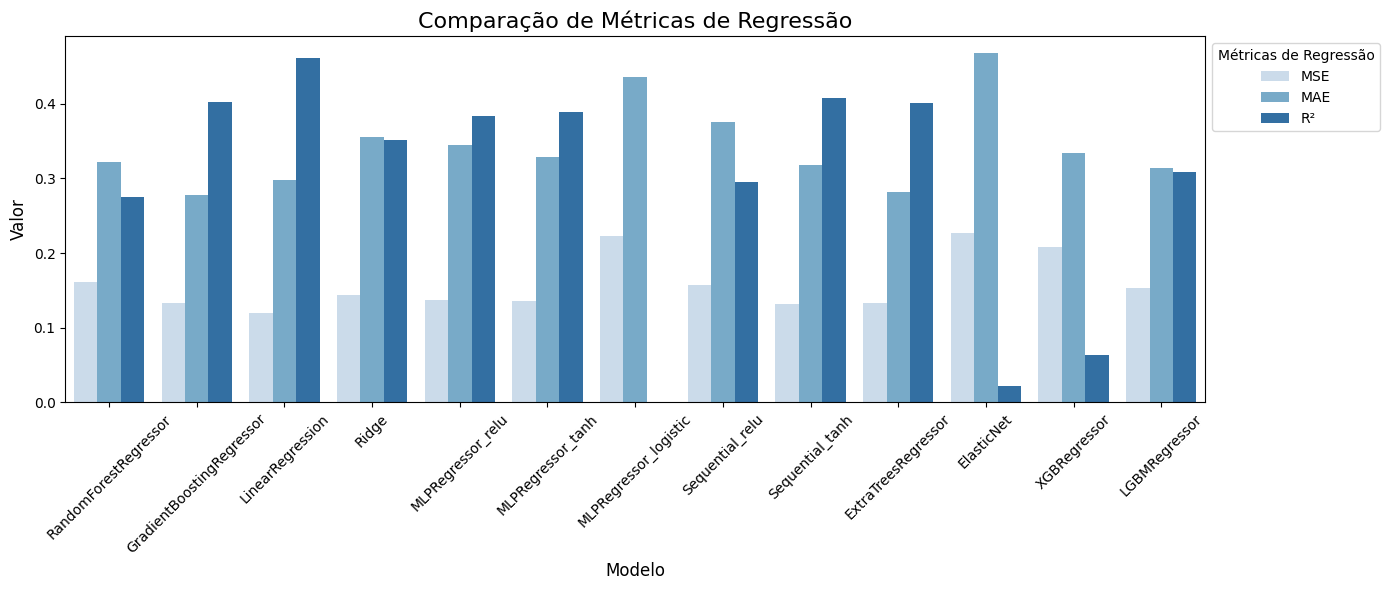

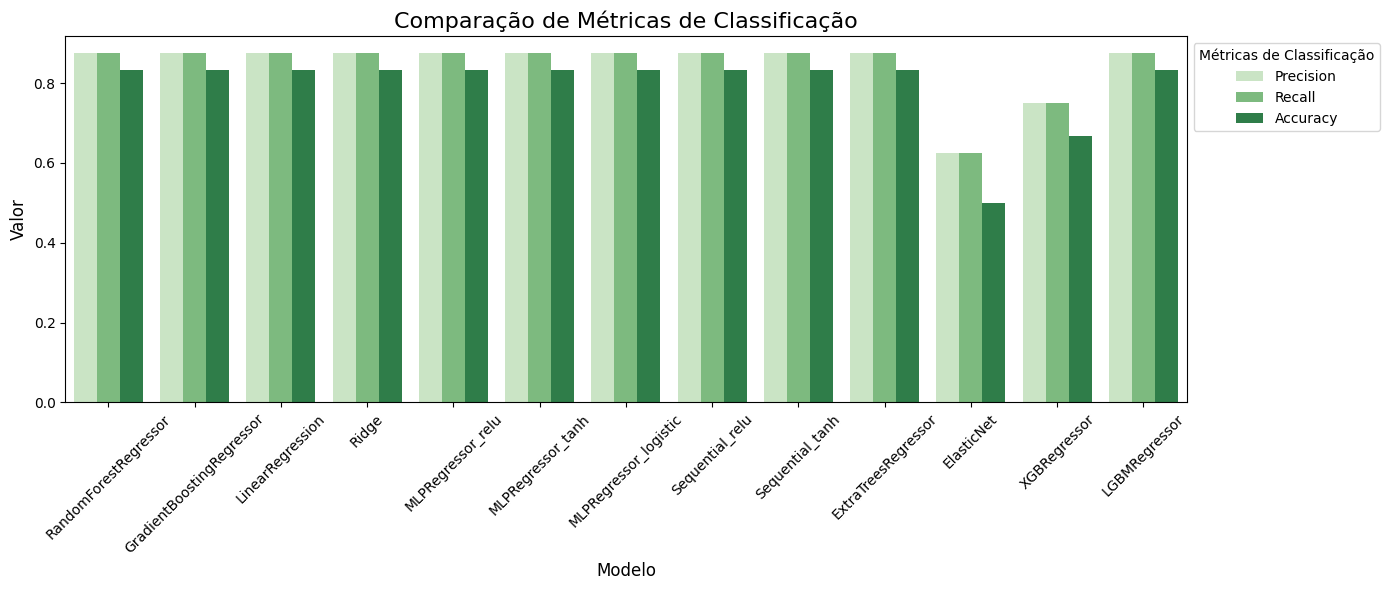

In [1202]:
#Condiredando os 8 melhores 1 e o resto 0

regression_metrics = ['MSE', 'MAE', 'R²']
classification_metrics = ['Precision', 'Recall', 'Accuracy']

# Transformar o DataFrame em formato longo
resultados_regression = resultados_8_melhores.melt(
    id_vars='Modelo', 
    value_vars=regression_metrics, 
    var_name='Métrica', 
    value_name='Valor'
)

resultados_classification = resultados_8_melhores.melt(
    id_vars='Modelo', 
    value_vars=classification_metrics, 
    var_name='Métrica', 
    value_name='Valor'
)

# Gráfico de métricas de regressão
plt.figure(figsize=(14, 6))
sns.barplot(data=resultados_regression, x='Modelo', y='Valor', hue='Métrica', palette='Blues')
plt.title('Comparação de Métricas de Regressão', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Métricas de Regressão', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Gráfico de métricas de classificação
plt.figure(figsize=(14, 6))
sns.barplot(data=resultados_classification, x='Modelo', y='Valor', hue='Métrica', palette='Greens')
plt.title('Comparação de Métricas de Classificação', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Métricas de Classificação', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

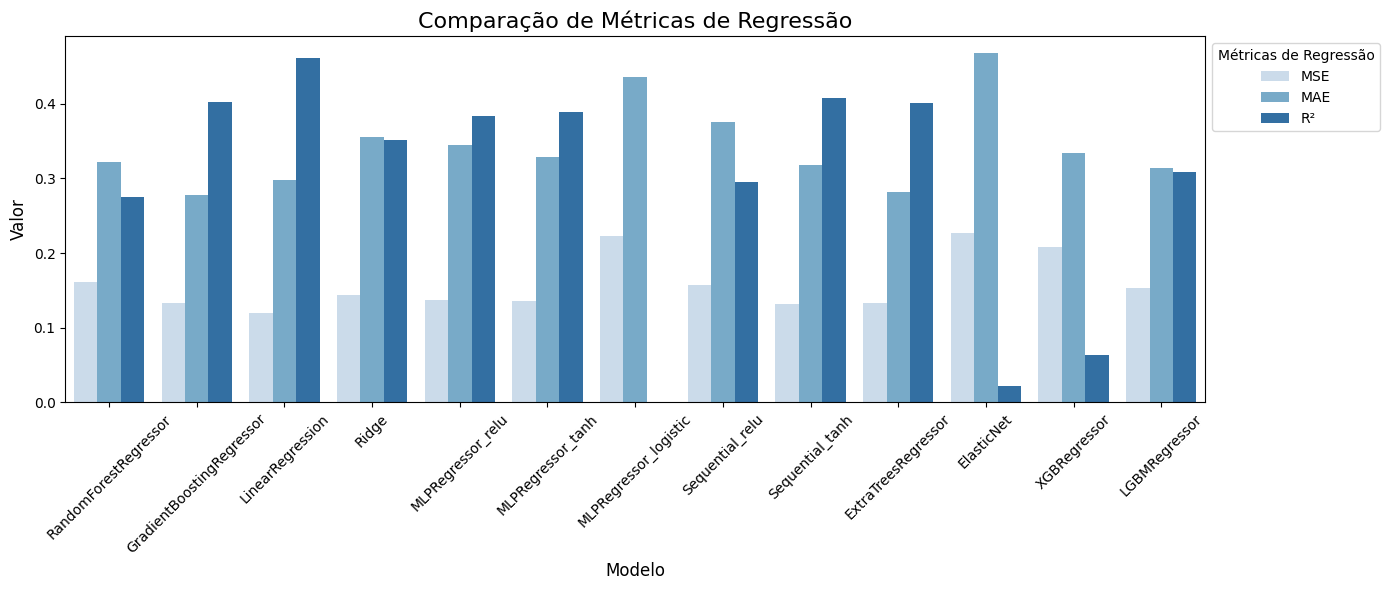

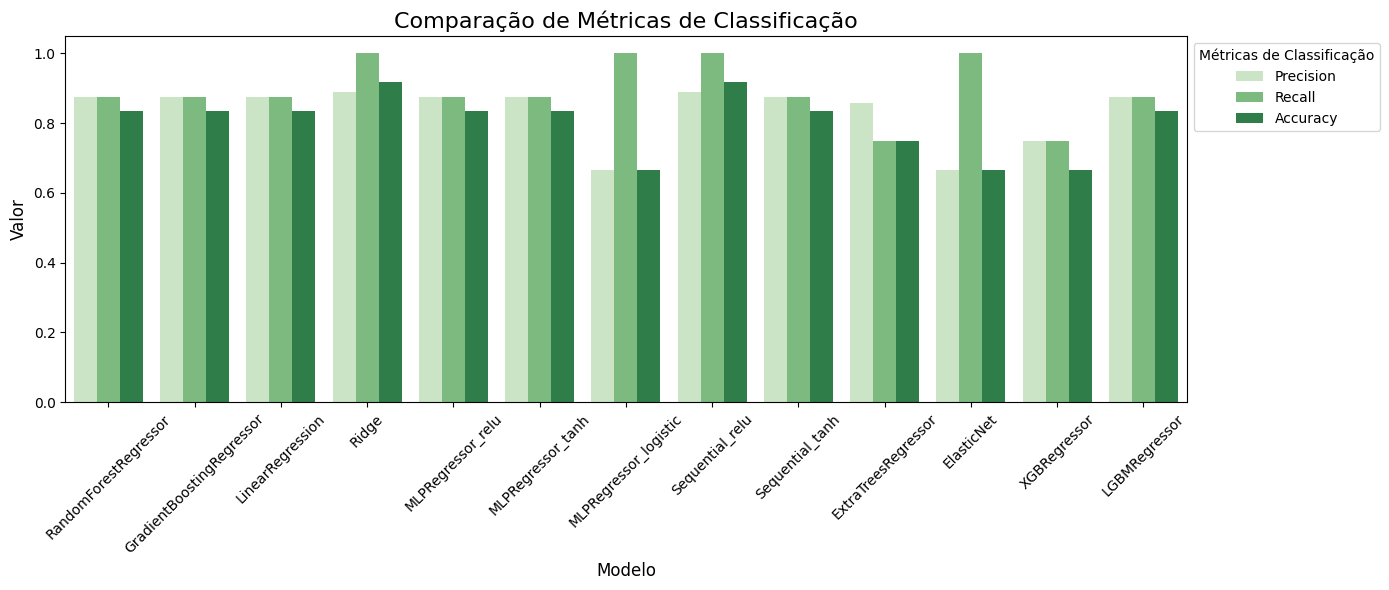

In [1203]:
#Condiredando os 0.5 para cima 1, se nao 0
regression_metrics = ['MSE', 'MAE', 'R²']
classification_metrics = ['Precision', 'Recall', 'Accuracy']

# Transformar o DataFrame em formato longo
resultados_regression = resultados_cima_baixo.melt(
    id_vars='Modelo', 
    value_vars=regression_metrics, 
    var_name='Métrica', 
    value_name='Valor'
)

resultados_classification = resultados_cima_baixo.melt(
    id_vars='Modelo', 
    value_vars=classification_metrics, 
    var_name='Métrica', 
    value_name='Valor'
)

# Gráfico de métricas de regressão
plt.figure(figsize=(14, 6))
sns.barplot(data=resultados_regression, x='Modelo', y='Valor', hue='Métrica', palette='Blues')
plt.title('Comparação de Métricas de Regressão', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Métricas de Regressão', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Gráfico de métricas de classificação
plt.figure(figsize=(14, 6))
sns.barplot(data=resultados_classification, x='Modelo', y='Valor', hue='Métrica', palette='Greens')
plt.title('Comparação de Métricas de Classificação', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Métricas de Classificação', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

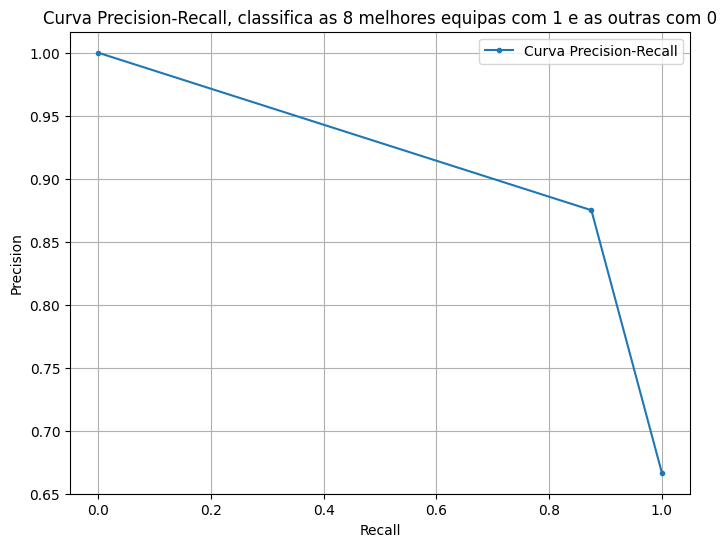

In [1204]:
# Criar o DataFrame com os dados necessários
dataset_8_melhores = pd.DataFrame({
    "playoff": dataset_resultados["playoff"],
    "prev_regression": dataset_resultados["GradientBoostingRegressor"]
})

# Ordenar o DataFrame pela coluna 'prev_regression' de forma decrescente
dataset_8_melhores_sorted = dataset_8_melhores.sort_values('prev_regression', ascending=False)

# Criar a nova coluna 'top_8' que marca as 8 melhores entradas como 1 e as outras como 0
dataset_8_melhores_sorted['top_8'] = 0

# Marcar as 8 melhores previsões como 1
dataset_8_melhores_sorted.iloc[:8, dataset_8_melhores_sorted.columns.get_loc('top_8')] = 1

# Reordenar o DataFrame para a ordem original
dataset_8_melhores_final = dataset_8_melhores_sorted.sort_index()

# Assumindo que 'top_8' seja a variável de verdade (y_true)
y_true = dataset_8_melhores_final['top_8']

# Encontrar o limiar de corte para as 8 melhores entradas em 'prev_regression'
threshold = dataset_8_melhores_final['prev_regression'].nlargest(8).min()

# Converter as previsões de 'prev_regression' em binário, onde 1 significa estar entre as 8 melhores previsões
y_pred = (dataset_8_melhores_final['prev_regression'] >= threshold).astype(int)

# Para mudar o nome de uma coluna, basta usar o método rename
dataset_8_melhores_final = dataset_8_melhores_final.rename(columns={'top_8': 'prev_class'})

#......................Desenhar a curva.................................
from sklearn.metrics import precision_recall_curve

# Supondo que 'dataset_8_melhores_final' tenha as colunas 'playoff' e 'prev_class'
y_true = dataset_8_melhores_final['playoff']  # Rótulos reais
y_scores = dataset_8_melhores_final['prev_class']  # Probabilidades ou escores de previsão

# Calcular a curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Plotar a curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall, classifica as 8 melhores equipas com 1 e as outras com 0')
plt.grid(True)
plt.legend()
plt.show()





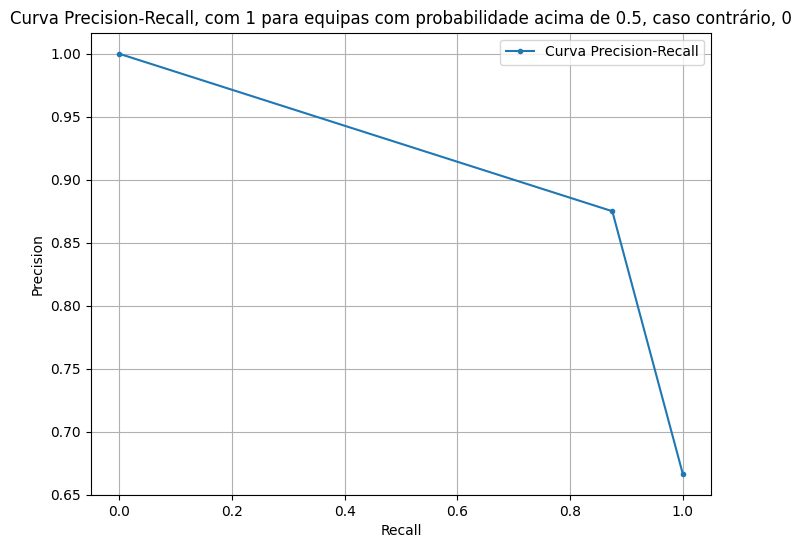

In [1205]:
#Precision recall curve para cima e baixo

# Criar o DataFrame com os dados necessários
dataset_cima_baixo = pd.DataFrame({
    "playoff": dataset_resultados["playoff"],
    "prev_regression": dataset_resultados["GradientBoostingRegressor"]
})

# Criar uma nova coluna 'prev_class' com base na condição
dataset_cima_baixo['prev_class'] = np.where(dataset_cima_baixo['prev_regression'] > 0.5, 1, 0)

#......................Desenhar a curva.................................
from sklearn.metrics import precision_recall_curve

y_true = dataset_cima_baixo['playoff']  # Rótulos reais
y_scores = dataset_cima_baixo['prev_class']  # Probabilidades ou escores de previsão

# Calcular a curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Plotar a curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall, com 1 para equipas com probabilidade acima de 0.5, caso contrário, 0')
plt.grid(True)
plt.legend()
plt.show()
